# Clase 24: Ajuste de mínimos cuadrados

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vimos los métodos de interpolación para los cuales se exige que un polinomio pase por una serie de puntos $(x_o, y_o), ..., (x_n, y_n)$. Pero hay dos situaciones en las que esto no es práctico:

Cuando los datos vienen de una medición, las mediciones vienen con un error, y hacer una interpolación de alto orden puede conllevar a oscilaciones. Además, como veremos la próxima clase, usar demasiados parámetros libres para ajustar datos experimentales es errado desde un punto de vista estadístico.

In [2]:
x = np.linspace(0, 1, 10)
func = x**2
n = np.random.normal(0, 0.02, 10)
med = func + n

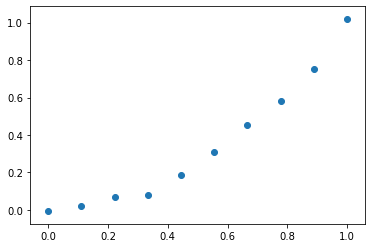

In [3]:
plt.scatter(x, med)

In [4]:
def difer(puntos):
    
    n = len(puntos) - 1
    Fs = [np.zeros(n + 1)]
    for i in range(n + 1):
        Fs[0][i] = puntos[i][1]
    for i in range(1, n + 1):
        Fs.append(np.zeros(n + 1 - i))
        for j in range(1, i + 1):
            Fs[j][i-j] = (Fs[j-1][i-j+1] - Fs[j-1][i-j])/(puntos[i][0] - puntos[i-j][0])
    
    return [Fs[i][0] for i in range(n + 1)]

def poly(x, coefs, puntos):
    return sum(coefs[n]*np.prod([(x - puntos[i,0]) for i in range(n)]) for n in range(len(coefs)))

In [5]:
puntos  = np.array(list(zip(x, med)))
coefs = difer(puntos)

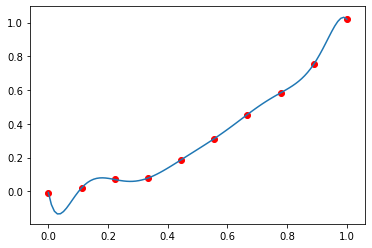

In [6]:
x = np.linspace(0, 1, 100)
plt.plot(x, [poly(xi, coefs, puntos) for xi in x])
plt.scatter(puntos[:,0], puntos[:,1], color='red')

In [7]:
coefs

[-0.007215843727261753,
 0.24297330113920518,
 0.9403939674077513,
 -7.942544859679486,
 56.81352997807232,
 -213.32450177285372,
 548.4559285104664,
 -1109.8262404728075,
 1958.1568946774742,
 -3144.434478132942]

Como vemos, el polinomio de alto orden no es un buen ajuste a estos datos. Y de hecho vemos que tiene coeficientes relativamente grandes hasta de orden 10, cuando sabemos que los datos son una parábola. Podríamos interpolar entre cada par de puntos usando una spline, pero entonces no podemos recuperar el modelo a partir de los datos.

Adicionalmente, tenemos 10 coeficientes para 10 puntos de datos. Siempre es posible ajustar un número de coeficientes igual al número de datos pero esto tiende a inducir las oscilaciones que vemos arriba, a esto se lo llama "overfitting" o sobreajuste. 

Surge entonces una pregunta: ¿Cuál es el mejor polinomio de orden más bajo que se ajusta a los datos? Es decir, queremos que ese polinomio se "acerque lo más posible a los datos". Adicionalmente, ¿qué criterio debemos usar para decidir si es un buen ajuste?

El segundo motivo es méramente práctico. Tal vez queremos encontrar un polinomio que aproxime una función en muchos puntos y no sólo en un cierto conjunto determinado, veamos:

In [8]:
def f(x):
    return 20*x*np.exp(-5*x) + np.sin(x)

In [9]:
xp = np.linspace(0, 5, 10)
puntos  = np.array(list(zip(xp, f(xp))))
coefs = difer(puntos)

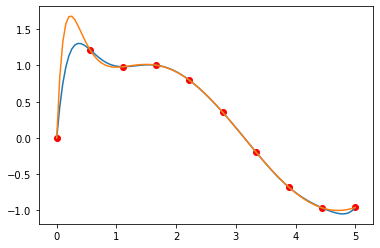

In [11]:
x = np.linspace(0, 5, 100)
plt.plot(x, [poly(xi, coefs, puntos) for xi in x])
plt.plot(x, f(x))
plt.scatter(puntos[:,0], puntos[:,1], color='red')

¿Podemos encontrar una función interpolante que se aproxime a la función completa?

## Ajuste de mínimos cuadrados

La respuesta a ambas preguntas tiene que ver con el ajuste de mínimos cuadrados. Consideremos primero el caso de las mediciones.

Supongamos que tenemos un modelo, que depende de varios parámetros libres (que queremos medir) $f(\vec{\theta}; x)$ donde $\vec{\theta} = (\theta_1,...,\theta_n)$ son los parámetros libres.

Nuestros datos consisten de varios puntos $(x_o, \hat{y}_o), ..., (x_m, \hat{y}_m)$ tal que $f(\vec{\theta}; x) = y$. Sin embargo los datos $\hat{y}$ contienen un error de medición $\hat{y}_i = y_i + \sigma_i$, y tenemos que tomarlo en cuenta a la hora de encontrar los parámetros $\theta$.

Si el error es gaussiano, la probabilidad de obtener un cierto valor $\hat{y}_i$ es proporcional a

$$
P(\hat{y}_i) \propto \exp\left({-(\hat{y}_i - y_i)^2/\sigma_i}\right)
$$

Si todos los datos son independientes, la probabilidad de obtener el conjunto de datos total será entonces la multiplicación de probabilidades, proporcional a

$$
P(\hat{y}) \propto \exp\left(-\sum_i(\hat{y}_i - y_i)^2/\sigma_i\right)
$$

pero en realidad esta probabilidad no la conocemos a-priori porque no conocemos los verdaderos valores $y_i$. Uno podría usar el modelo y escribir

$$
P(\hat{y} | \vec{\theta}) \propto \exp\left\{-\sum_i\left[\hat{y}_i - f(\vec{\theta};x_i)\right]^2/\sigma_i\right\}
$$

A esta se la llama función de verosimilitud (likelihood).

En realidad lo que queremos es lo contrario: La probabilidad de que el verdadero valor de los parámetros sea $\tilde{\theta}$ dadas las mediciones (las mediciones las tenemos, los parámetros los queremos obtener). Esto se puede lograr usando el teorema de Bayes

$$
P(\vec{\theta}|\hat{y}) = \frac{P(\hat{y} | \vec{\theta}) P(\vec{\theta})}{P(\hat{y})}
$$

Si asumimos que $P(\vec{\theta})$ es una función constante (a-priori cualquier valor es igualmente probable), entonces el conjunto de parámetros que maximiza $P(\vec{\theta}|\hat{y})$ es el que maximiza $P(\vec{\theta}|\hat{y})$. Entonces esto se reduce a minimizar la función

$$
\chi^2 \equiv \sum_i\frac{\left[\hat{y}_i - f(\vec{\theta};x_i)\right]^2}{\sigma_i}
$$

Si todos los errores son iguales $\sigma_i = \sigma$ entonces esto se reduce a minimizar la suma de los cuadrados

$$
E(\vec{\theta}) = \sum_i\left[\hat{y}_i - f(\vec{\theta};x_i)\right]^2
$$

Podemos por ejemplo hacer un ajuste de una recta $f(a_o, a_1; x) = a_o + a_1 x$ y entonces

$$
E(a_o, a_1) =  \sum_i\left[\hat{y}_i - (a_o + a_1 x_i)\right]^2 = \sum_i \hat{y}_i^2 - 2\sum_i (a_o + a_1 x_i)\hat{y}_i + \sum_i (a_o + a_1 x_i)^2
$$

El mínimo cumplirá que la derivada respecto a los parámetros es cero

$$
\begin{align}
\frac{\partial}{\partial a_o} E(a_o, a_1) &=  -2\sum_i \hat{y}_i + 2\sum_i (a_o + a_1 x_i) \\
\frac{\partial}{\partial a_1} E(a_o, a_1) &=  -2\sum_i \hat{y}_i x_i + 2\sum_i x_i (a_o + a_1 x_i)
\end{align}
$$

Entonces el problema se reduce a resolver el sistema de ecuaciones

$$
\begin{align}
m a_o + \alpha_1 a_1 &= \beta_1\\
\alpha_1 a_o + \alpha_2 a_1 &= \beta_2
\end{align}
$$

con

$$
\alpha_1 = \sum_i x_i\,, \quad \alpha_2 = \sum_i x_i^2\,,\quad \beta_1 = \sum_i y_i\,,\quad \beta_2 = \sum_i y_i x_i\,.
$$

de donde deducimos

$$
\begin{align}
a_o &= \frac{\alpha_2\beta_1 - \alpha_1\beta_2}{m\alpha_2 - \alpha_1^2} \\
a_1 &= \frac{m\beta_2 - \alpha_1 \beta_1}{m\alpha_2 - \alpha_1^2 }
\end{align}
$$

In [15]:
def lin_fit(puntos):
    
    alpha1 = sum(puntos[:,0])
    alpha2 = sum(puntos[:,0]**2)
    beta1 = sum(puntos[:,1])
    beta2 = sum(puntos[:,1]*puntos[:,0])
    m = len(puntos)
    
    ao = (alpha2*beta1 - alpha1*beta2)/(m*alpha2 - alpha1**2)
    a1 = (m*beta2 - alpha1*beta1)/(m*alpha2 - alpha1**2)
    
    return ao, a1

In [16]:
err = 0.02
x = np.linspace(0, 1, 10)
func = x**2
n = np.random.normal(0, err, 10)
med = func + n

In [17]:
x = np.linspace(0, 1, 10)
puntos  = np.array(list(zip(x, med)))
ao, a1 = lin_fit(puntos)

<ErrorbarContainer object of 3 artists>

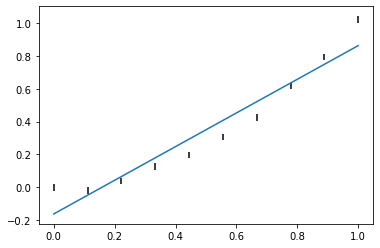

In [18]:
x = np.linspace(0, 1, 100)
plt.plot(x, ao + a1*x)
plt.errorbar(puntos[:,0], puntos[:,1], yerr=err , color='black', linestyle='None')

Análogamente si queremos ajustar una parábola

$$
\begin{align}
\frac{\partial}{\partial a_o} E(a_o, a_1, a_2) &=  -2\sum_i \hat{y}_i + 2\sum_i (a_o + a_1 x_i + a_2 x_i^2) \\
\frac{\partial}{\partial a_1} E(a_o, a_1, a_2) &=  -2\sum_i \hat{y}_i x_i + 2\sum_i x_i (a_o + a_1 x_i + a_2 x_i^2) \\
\frac{\partial}{\partial a_2} E(a_o, a_1, a_2) &=  -2\sum_i \hat{y}_i x_i^2 + 2\sum_i x_i^2 (a_o + a_1 x_i + a_2 x_i^2)
\end{align}
$$

Entonces el problema se reduce a resolver el sistema de ecuaciones

$$
\begin{align}
m a_o + \alpha_1 a_1 + \alpha_2 a_2 &= \beta_1\\
\alpha_1 a_o + \alpha_2 a_1 + \alpha_3 a_2 &= \beta_2 \\
\alpha_2 a_o + \alpha_3 a_1 + \alpha_4 a_2 &= \beta_3
\end{align}
$$

con

$$
\alpha_p = \sum_i x_i^p\,,\quad \beta_p = \sum_i y_i x_i^{(p - 1)}\,.
$$

de donde deducimos

$$
\begin{align}
a_o &= -\frac{\alpha_1 \alpha_3 \beta_3-\alpha_1\alpha_4 \beta_2+\alpha_2^2 (-\beta_3)+\alpha_2 \alpha_3 \beta_2+\alpha_2\alpha_4 \beta_1-\alpha_3^2 \beta_1}{\alpha_1^2 \alpha_4-2 \alpha_1 \alpha_2 \alpha_3+\alpha_2^3-\alpha_2 \alpha_4 m+\alpha_3^2 m} \\
a_1 &= -\frac{\alpha_1 \alpha_2 \beta_3-\alpha_1\alpha_4 \beta_1+\alpha_2^2 (-\beta_2)+\alpha_2 \alpha_3 \beta_1-\alpha_3\beta_3 m+\alpha_4 \beta_2 m}{\alpha_1^2\alpha_4-2 \alpha_1 \alpha_2 \alpha_3+\alpha_2^3-\alpha_2 \alpha_4 m+\alpha_3^2 m}\\
a_2 &= -\frac{\alpha_1^2 (-\beta_3)+\alpha_1 \alpha_2\beta_2+\alpha_1 \alpha_3 \beta_1- \alpha_2^2 \beta_1+\alpha_2 \beta_3 m-\alpha_3\beta_2 m}{\alpha_1^2 \alpha_4-2 \alpha_1\alpha_2 \alpha_3+\alpha_2^3-\alpha_2\alpha_4 m+\alpha_3^2 m}
\end{align}
$$

In [19]:
def quad_fit(puntos):
    
    alpha1 = sum(puntos[:,0])
    alpha2 = sum(puntos[:,0]**2)
    alpha3 = sum(puntos[:,0]**3)
    alpha4 = sum(puntos[:,0]**4)
    beta1 = sum(puntos[:,1])
    beta2 = sum(puntos[:,1]*puntos[:,0])
    beta3= sum(puntos[:,1]*puntos[:,0]**2)
    m = len(puntos)
    
    ao = -((-((alpha3)**2*beta1) + alpha2*alpha4*beta1 + alpha2*alpha3*beta2 \
            - alpha1*alpha4*beta2 - (alpha2)**2*beta3 + alpha1*alpha3*beta3)\
           /((alpha2)**3 - 2*alpha1*alpha2*alpha3 + (alpha1)**2*alpha4 \
             + (alpha3)**2*m - alpha2*alpha4*m))
    a1 = -((alpha2*alpha3*beta1 - alpha1*alpha4*beta1 - (alpha2)**2*beta2 \
            + alpha1*alpha2*beta3 + alpha4*beta2*m - alpha3*beta3*m)\
           /((alpha2)**3 - 2*alpha1*alpha2*alpha3 + (alpha1)**2*alpha4 \
             + (alpha3)**2*m - alpha2*alpha4*m))
    a2 = -((-((alpha2)**2*beta1) + alpha1*alpha3*beta1 + alpha1*alpha2*beta2 \
            - (alpha1)**2*beta3 - alpha3*beta2*m + alpha2*beta3*m)\
           /((alpha2)**3 - 2*alpha1*alpha2*alpha3 + (alpha1)**2*alpha4 \
             + (alpha3)**2*m - alpha2*alpha4*m))
    
    return ao, a1, a2

In [20]:
ao, a1, a2 = quad_fit(puntos)

<ErrorbarContainer object of 3 artists>

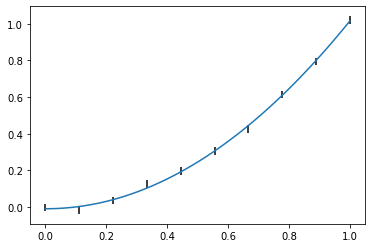

In [21]:
x = np.linspace(0, 1, 100)
plt.plot(x, ao + a1*x + a2*x**2)
plt.errorbar(puntos[:,0], puntos[:,1], yerr=err , color='black', linestyle='None')

In [22]:
ao

-0.009473129812439562

In [23]:
a1

-0.005464687685901462

In [24]:
a2

1.0300528107709659

## Scipy

Copiado de: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

Scipy tiene una función muy útil para realizar ajustes de curvas a datos, esta nos permite ajustar una función arbitraria con parámetros libres, incluyendo el caso en el que los puntos de datos tienen errores diferentes.

    scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=- inf, inf, method=None, jac=None, **kwargs)[source]

In [25]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

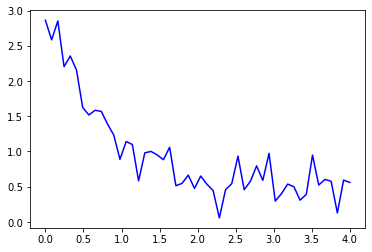

In [26]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

In [27]:
popt, pcov = curve_fit(func, xdata, ydata)
popt

array([2.55423706, 1.35190947, 0.47450618])

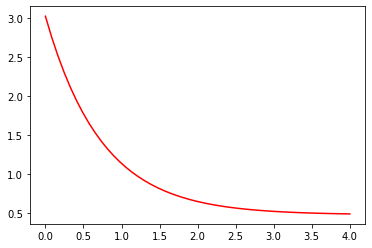

In [28]:
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

Se restringe el rango a $0 < a < 3$, $0 < b < 1$, $0 < c < 1/2$

In [29]:
popt2, pcov2 = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
popt2

array([2.43708906, 1.        , 0.35015434])

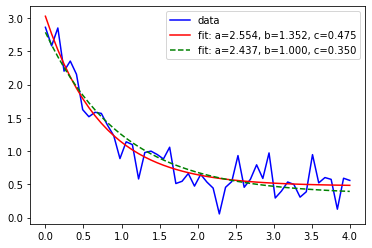

In [30]:
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(xdata, func(xdata, *popt2), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt2))
plt.legend()

## Ajuste de funciones

El segundo caso es continuo. Queremos encontrar un polinomio que aproxime una función lo mejor posible en todos sus puntos. Para eso podemos minimizar las distancias a la función:

$$
E = \int dx\,\left[f(x) - P(x)\right]^2
$$

Para encontrar el polinomio que minimiza $E$ es cómodo usar polinomios ortogonales $P_i$ tal que escribimos $P(x) = \sum_{i = 1}^n a_i P_i(x)$, de donde

$$
E = \int dx\,\left[f(x) - \sum_{i=1}^n a_i P_i(x) \right]^2
$$

y la idea es encontrar los coeficientes $a_i$ que minimizan esta integral. Tenemos

$$
\frac{\partial E}{\partial a_i} = -2\int dx\,f(x)P_i(x) + 2\sum_{j=1}^n a_j \int dx\,P_i(x) P_j(x)
$$

Para polinomios ortogonales $\int dx\,P_i(x) P_j(x) = \alpha_i \delta_{ij}$ y tenemos

$$
a_i = \frac{1}{\alpha_i}\int dx\,f(x)P_i(x)
$$

Por ejemplo la serie de Fourier truncada satisface lo visto arriba:

$$
S_n(x) = \frac{a_o}{2} + a_n \cos nx + \sum_{k=1}^{n-1}(a_k \cos kx + b_k \sin kx)
$$

In [31]:
ao = np.pi/2
ak = [2/(np.pi*k**2)*((-1)**k - 1) for k in range(1,10)]
def aprox(n, x):
    return np.full(len(x), ao) + sum(ak[k-1]*np.cos(k*x) for k in range(1,n+1))

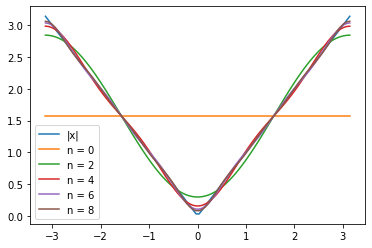

In [32]:
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x, np.abs(x), label='|x|')
for i in range(5):
    plt.plot(x, aprox(2*i, x), label='n = %d'%(2*i))
plt.legend()

Otro ejemplo importante son los polinomios de Chebyshev, que cumplen

$$
\int_{-1}^1 dx\,\frac{1}{\sqrt{1 - x^2}}T_m(x) T_n(x) = \frac{\pi}{2}\delta_{mn}
$$

Se pueden usar para minimizar

$$
E = \int_{-1}^1 dx\,\frac{1}{\sqrt{1-x^2}}\left[f(x) - \sum_{i=1}^n a_i T_i(x) \right]^2
$$

Lo interesante es que cumplen la siguuente propiedad para todo polinomio de orden $\leq n$

$$
\frac{1}{2^{n-1}} = \frac{1}{2^{n-1}}\max_{x \in [-1,1]} |T_n(x)| \leq \max_{x \in [-1,1]} |P(x)|
$$

Esto se puede usar para demostrar:

* Si $P(x)$ es el polinomio interpolante de Lagrange de orden $m$ para la función $f(x)$ evaluada en los $m$ ceros de $T_m(x)$ entonces

$$
\max_{x\in[-1,1]}|f(x) - P(x)| \leq \frac{1}{2^n(n+1)}\max_{x\in[-1,1]}|f^{(m+1)}(x)|
$$

* Si se quiere aproximar el polinomio $P_n(x)$ de orden $n$ con un polinomio de orden $n-1$, la elección que minimiza el error es

$$
P_{n-1}(x) = P_n(x) - \frac{a_n}{2^{n-1}}T_n(x)\,.
$$

y el error cometido es

$$
\max_{x\in[-1,1]}|P_n(x) - P_{n-1}(x)| = \frac{|a_n|}{2^{n-1}}
$$

In [33]:
def f(x):
    return 20*x*np.exp(-5*x) + np.sin(x)

In [34]:
from scipy.special import roots_chebyt
n = 10
xp = (roots_chebyt(n)[0] + 1)*5/2
xp_m = np.linspace(0,5,n)

In [35]:
puntos  = np.array(list(zip(xp, f(xp))))
coefs = difer(puntos)
puntos_m = np.array(list(zip(xp_m, f(xp_m))))
coefs_m = difer(puntos_m)

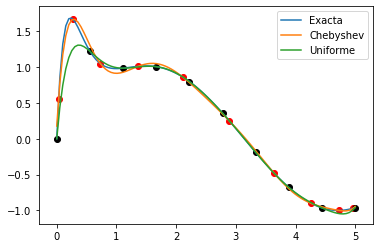

In [36]:
x = np.linspace(0, 5, 100)
plt.plot(x, f(x), label='Exacta')
plt.plot(x, [poly(xi, coefs, puntos) for xi in x], label='Chebyshev')
plt.plot(x, [poly(xi, coefs_m, puntos_m) for xi in x], label='Uniforme')
plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.scatter(puntos_m[:,0], puntos_m[:,1], color='black')
plt.legend()

## Tareas

### Tarea 12.6

Ejercicio 8.4.7 del libro de Burden:

Escriba el polinomio de Mclaurin de sexto orden para la función $xe^x$ y use los polinomios de Chebyshev para encontrar el polinomio de el orden menor posible que mantenga el error menor a $0.001$ sobre el intervalo $[-1,1]$.

**Pista**: Recuerde que el valor máximo de $T_n$ sobre $[-1,1]$ es $1$. Use la función chebval de numpy.polynomial.chebyshev

El poolinomio es

$$
xe^x \approx P_6(x) = x + x^2 + \frac{1}{2}x^3 + \frac{1}{6}x^4 + \frac{1}{24}x^5 + \frac{1}{120}x^6 + ...
$$

el error es

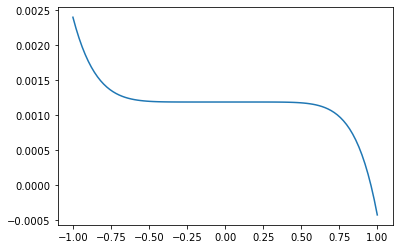

In [43]:
def aprox0(x):
    return x + x**2 + (1/2)*x**3 + (1/6)*x**4 + (1/24)*x**5 + (1/120)*x**6 + (1/840)

x = np.linspace(-1,1,100)
plt.plot(x, aprox0(x) - x*np.exp(x))

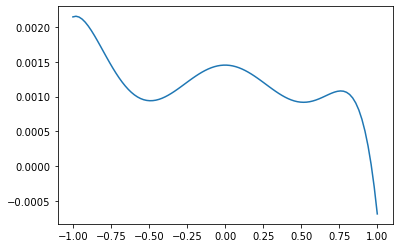

In [49]:
def aprox1(x):
    return aprox0(x) - np.polynomial.chebyshev.chebval(x, [0,0,0,0,0,0,1/(2**(5))/120])

plt.plot(x, aprox1(x) - x*np.exp(x))

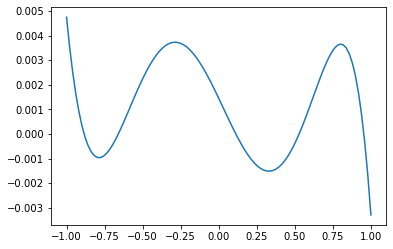

In [53]:
def aprox2(x):
    return aprox0(x) - np.polynomial.chebyshev.chebval(x, [0,0,0,0,0,1/(2**4)/24,1/(2**(5))/120])

plt.plot(x, aprox2(x) - x*np.exp(x))

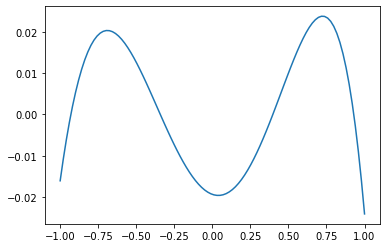

In [54]:
def aprox3(x):
    return aprox0(x) - np.polynomial.chebyshev.chebval(x, [0,0,0,0,1/(2**3)/6,1/(2**4)/24,1/(2**(5))/120])

plt.plot(x, aprox3(x) - x*np.exp(x))

De modo que el polinomio de menor orden que aproxima la función en $[-1,1]$ manteniendo un error menor a $0.01$ es de orden $4$ y está dado por

$$
P_6(x) - \frac{1}{2^5\times 120}T_6(x) - \frac{1}{2^4\times 24}T_5(x)
$$

### Tarea 12.7

Use scipy para resolver el siguiente problema:

Queremos medir los parámetros $a$, $b$ y $k$ del siguiente modelo $f(x) = a e^{kx} + b$ a partir de las siguientes mediciones

|$x$|$f(x)$|$\sigma$|
|-|-|-|
|$1$|$6.54$|$0.1$|
|$2$|$7.57$|$0.3$|
|$3$|$8.83$|$0.1$|
|$4$|$10.43$|$0.2$|
|$5$|$12.95$|$0.05$|

Encuentre los valores de los parámetros que mejor se ajustan a los datos. ¿Es un buen ajuste? (para responder estto último ver la clase 25).

In [75]:
from scipy.optimize import curve_fit

def f(x, a, b, k):
    return a*np.exp(k*x) + b

xdata = np.array([1,2,3,4,5],dtype=float)
ydata = np.array([6.54, 7.57, 8.83, 10.43, 12.95])
sigma = np.array([0.1, 0.3, 0.1, 0.2, 0.05])

popt, pcov = curve_fit(f, xdata, ydata, sigma=sigma)

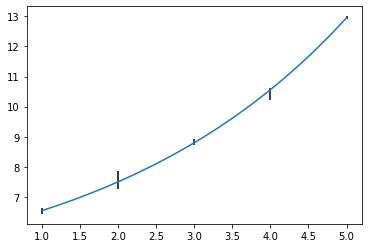

In [76]:
x = np.linspace(1,5,20)
plt.errorbar(xdata, ydata, yerr=sigma , color='black', linestyle='None')
plt.plot(x, f(x,*popt))

In [78]:
r = ydata - f(xdata, *popt)
sum(r**2/sigma**2)/(5-3)

0.2827622326198417

Como el $\chi^2$ reducido es de orden $1$ podemos decir que es un buen ajuste.

### Tarea 12.8

En clase vimos cómo ajustar una línea recta a un conjunto de datos cuando el error de todos los datos es el mismo. Repita el ejercicio para los siguientes datos (que tienen todos un error diferente):

|$x$|$f(x)$|$\sigma$|
|-|-|-|
|$0.1$|$5.71$|$0.2$|
|$0.2$|$7.21$|$0.3$|
|$0.3$|$8.07$|$0.2$|
|$0.4$|$9.73$|$0.4$|
|$0.5$|$10.06$|$0.05$|

¿Es un buen ajuste? (para responder esto último, ver la clase 25)

**Solución:** Repetimos la derivación dada en clase:

Hacemos el ajuste de una recta $f(a_o, a_1; x) = a_o + a_1 x$ y minimizamos la función

$$
E(a_o, a_1) =  \sum_i\left[\frac{\hat{y}_i - (a_o + a_1 x_i)}{\sigma_i}\right]^2 = \sum_i \frac{\hat{y}_i^2}{\sigma_i^2} - 2\sum_i \frac{(a_o + a_1 x_i)\hat{y}_i}{\sigma_i^2} + \sum_i \frac{(a_o + a_1 x_i)^2}{\sigma_i^2}
$$

El mínimo cumplirá que la derivada respecto a los parámetros es cero

$$
\begin{align}
\frac{\partial}{\partial a_o} E(a_o, a_1) &=  -2\sum_i \frac{\hat{y}_i}{\sigma_i^2} + 2\sum_i \frac{(a_o + a_1 x_i)}{\sigma_i^2} \\
\frac{\partial}{\partial a_1} E(a_o, a_1) &=  -2\sum_i \frac{\hat{y}_i x_i}{\sigma_i^2} + 2\sum_i \frac{x_i (a_o + a_1 x_i)}{\sigma_i^2}
\end{align}
$$

Entonces el problema se reduce a resolver el sistema de ecuaciones

$$
\begin{align}
\alpha_o a_o + \alpha_1 a_1 &= \beta_1\\
\alpha_1 a_o + \alpha_2 a_1 &= \beta_2
\end{align}
$$

con

$$
\alpha_o = \sum_i \frac{1}{\sigma_i^2}\,,\quad \alpha_1 = \sum_i \frac{x_i}{\sigma_i^2}\,, \quad \alpha_2 = \sum_i \frac{x_i^2}{\sigma_i^2}\,,\quad \beta_1 = \sum_i \frac{y_i}{\sigma_i^2}\,,\quad \beta_2 = \sum_i \frac{y_i x_i}{\sigma_i^2}\,.
$$

de donde deducimos

$$
\begin{align}
a_o &= \frac{\alpha_2\beta_1 - \alpha_1\beta_2}{\alpha_o\alpha_2 - \alpha_1^2} \\
a_1 &= \frac{\alpha_o\beta_2 - \alpha_1 \beta_1}{\alpha_o\alpha_2 - \alpha_1^2 }
\end{align}
$$

In [79]:
def lin_fit_sigma(xdata, ydata, sigma):
    
    alpha0 = sum(1/sigma**2)
    alpha1 = sum(xdata/sigma**2)
    alpha2 = sum(xdata**2/sigma**2)
    beta1 = sum(ydata/sigma**2)
    beta2 = sum(ydata*xdata/sigma**2)
    
    ao = (alpha2*beta1 - alpha1*beta2)/(alpha0*alpha2 - alpha1**2)
    a1 = (alpha0*beta2 - alpha1*beta1)/(alpha0*alpha2 - alpha1**2)
    
    return ao, a1

In [80]:
xdata = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
ydata = np.array([5.71, 7.21, 8.07, 9.73, 10.06])
sigma = np.array([0.2, 0.3, 0.2, 0.4, 0.05])

In [81]:
ao, a1 = lin_fit_sigma(xdata, ydata, sigma)

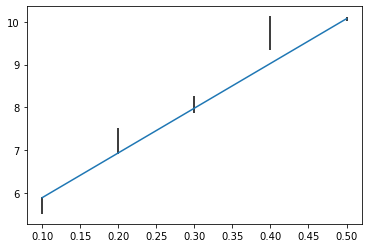

In [83]:
x = np.linspace(0.1,0.5,20)
plt.errorbar(xdata, ydata, yerr=sigma , color='black', linestyle='None')
plt.plot(x, ao + a1*x)

In [85]:
r = ydata - ao - a1*xdata
sum(r**2/sigma**2)/(5-2)

1.665236959064327

de nuevo el ajuste es bueno porque el $\chi^2$ reducido es de orden $1$.

### Tarea 12.9

Use los polinomios de Legendre para ajustar la función $f(x) = |x|$ en el intervalo $[-1,1]$. Es decir, encuentre los coeficientes de la expansión

$$
f(x) = \sum_{i=0}^n a_i P_i(x)
$$

Hágalo para $n$ desde $0$ hasta $6$ y grafique sus resultados.

**Solución:** Los coeficientes están dados por 

$$
a_i = \frac{(2i + 1)}{2}\int_{-1}^1 dx\,P_i(x)f(x)
$$

como $f(x)$ es par y $P_i(x)$ es impar para $i$ impar, sabemos que los coeficientes correspondientes son cero. Los demás están dados por los polinomios de Legendre:

$$
P_o(x) = 1\,,\quad P_2(x) = \frac{1}{2}(3x^2 - 1)\,,\quad P_4(x) = \frac{1}{8}(35x^4 - 30x^2 + 3)\,,\quad P_6 = \frac{1}{16}(231x^6 - 315x^4 + 105x^2 - 5)
$$

Las integrales son

$$
a_o = \frac{1}{2}\,,\quad a_2 = \frac{5}{2}\left(\frac{3}{4} - \frac{1}{2}\right)\,,\quad a_4 = \frac{9}{2}\frac{1}{4}\left(\frac{35}{6} - \frac{15}{2} + \frac{3}{2}\right)\,,\quad a_6 = \frac{13}{2}\frac{1}{8}\left(\frac{231}{8} - \frac{105}{2} + \frac{105}{4} - \frac{5}{2}\right)
$$

In [101]:
legs = [lambda x: 1, lambda x: (1/2)*(3*x**2 - 1),
       lambda x: (1/8)*(35*x**4 - 30*x**2 + 3),
       lambda x: (1/16)*(231*x**6 - 315*x**4 + 105*x**2 - 5)]
ais = [1/2, (5/2)*(3/4-1/2), (9/2)*(1/4)*(35/6-15/2+3/2), 
       (13/2)*(1/8)*(231/8-105/2+105/4-5/2)]
def aprox(n, x):
    ind = int(n//2)
    return np.full(len(x),ais[0]) + sum(ais[i+1]*legs[i+1](x) for i in range(ind))

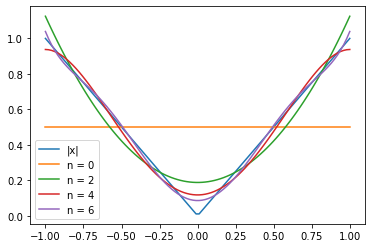

In [104]:
x = np.linspace(-1, 1, 100)
plt.plot(x, np.abs(x), label='|x|')
for i in range(4):
    plt.plot(x, aprox(2*i, x), label='n = %d'%(2*i))
plt.legend()

### Tarea 12.10

Este ejercicio necesita el material de la clase 25.

Considere los siguientes datos:

|$x$|$f(x)$|$\sigma$|
|-|-|-|
|$0.1$| $0.280$ |$0.1$|
|$0.2$| $0.472$ |$0.07$|
|$0.3$| $0.686$ |$0.05$|
|$0.4$| $0.850$ |$0.1$|
|$0.5$| $1.263$ |$0.03$|
|$0.6$| $1.576$ |$0.01$|
|$0.7$| $1.894$ |$0.01$|

Use scipy para ajustar los siguientes modelos:

* $a_1 x$
* $a_1 x + a_2 x^2$
* $a_o + a_1 x + a_2 x^2$

¿Cuál modelo describe mejor los datos? ¿Por qué?

Ahora repita lo mismo con los siguientes datos:

|$x$|$f(x)$|$\sigma$|
|-|-|-|
|$0.1$| $-1.36$ |$2.0$|
|$0.2$| $0.20$ |$1.4$|
|$0.3$| $3.01$ |$1.0$|
|$0.4$| $0.30$ |$2.0$|
|$0.5$| $1.11$ |$0.6$|
|$0.6$| $1.52$ |$0.2$|
|$0.7$| $2.09$ |$0.2$|

Ambos datos fueron generados a partir de la misma función $f$. Explique por qué cambian los resultados.

In [131]:
from scipy.optimize import curve_fit

def f1(x, a1):
    return a1*x

def f2(x, a1, a2):
    return a1*x + a2*x**2

def f3(x, a0, a1, a2):
    return a0 + a1*x + a2*x**2

xdata = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ydata = np.array([0.280, 0.472, 0.686, 0.850, 1.263, 1.576, 1.894])
sigma = np.array([0.1, 0.07, 0.05, 0.1, 0.054, 0.01, 0.01])

popt1, pcov1 = curve_fit(f1, xdata, ydata, sigma=sigma)
popt2, pcov2 = curve_fit(f2, xdata, ydata, sigma=sigma)
popt3, pcov3 = curve_fit(f3, xdata, ydata, sigma=sigma)

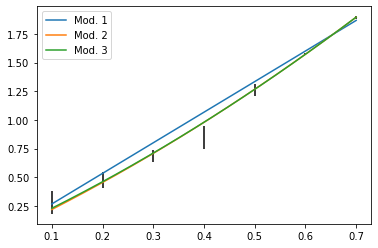

In [132]:
x = np.linspace(0.1,0.7,20)
plt.errorbar(xdata, ydata, yerr=sigma , color='black', linestyle='None')
plt.plot(x, f1(x,*popt1), label='Mod. 1')
plt.plot(x, f2(x,*popt2), label='Mod. 2')
plt.plot(x, f3(x,*popt3), label='Mod. 3')
plt.legend()

In [133]:
r1 = ydata - f1(xdata, *popt1)
sum(r1**2/sigma**2)/(7-1)

4.265496770453821

In [134]:
r2 = ydata - f2(xdata, *popt2)
sum(r2**2/sigma**2)/(7-2)

0.48747372216954454

In [135]:
r3 = ydata - f3(xdata, *popt3)
sum(r3**2/sigma**2)/(7-3)

0.6025715972438214

El mejor ajuste es el segundo modelo sgún el $\chi^2$ reducido. 

In [136]:
popt2

array([2.09772932, 0.87230613])

Ahora repetimos para los otros datos

In [143]:
from scipy.optimize import curve_fit

def f1(x, a1):
    return a1*x

def f2(x, a1, a2):
    return a1*x + a2*x**2

def f3(x, a0, a1, a2):
    return a0 + a1*x + a2*x**2

xdata = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ydata = np.array([-1.36, 0.2, 3.01, 0.30, 1.11, 1.52, 2.09])
sigma = np.array([2, 1.4, 1, 2, 0.6, 0.2, 0.2])

popt1, pcov1 = curve_fit(f1, xdata, ydata, sigma=sigma)
popt2, pcov2 = curve_fit(f2, xdata, ydata, sigma=sigma)
popt3, pcov3 = curve_fit(f3, xdata, ydata, sigma=sigma)

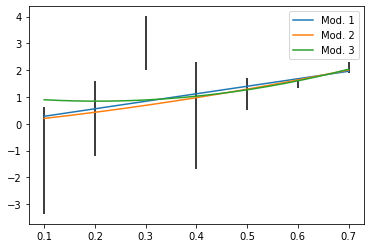

In [144]:
x = np.linspace(0.1,0.7,20)
plt.errorbar(xdata, ydata, yerr=sigma , color='black', linestyle='None')
plt.plot(x, f1(x,*popt1), label='Mod. 1')
plt.plot(x, f2(x,*popt2), label='Mod. 2')
plt.plot(x, f3(x,*popt3), label='Mod. 3')
plt.legend()

In [145]:
r1 = ydata - f1(xdata, *popt1)
sum(r1**2/sigma**2)/(7-1)

1.1519288714758495

In [146]:
r2 = ydata - f2(xdata, *popt2)
sum(r2**2/sigma**2)/(7-2)

1.3459393596158573

In [147]:
r3 = ydata - f3(xdata, *popt3)
sum(r3**2/sigma**2)/(7-3)

1.6089467243217646

Para estos datos, el mejor ajuste es el primer modelo aunque todos dan un buen ajuste. Esto es porque ahora las barras de error son grandes y los datos no tienen la precisión para distinguir entre modelos, tal que el $\chi^2$ tiende a preferir el más sencillo.